# Solving PDEs with PyTorch

This file contains our first approach to solve PDEs with neural networks on the PyTorch Library.  
We will try to solve the poisson Equation :  
$-\Delta u(x) = f(x)$ on $\Omega = [0,1]^2$  
With Dirichlet homogeneous boundary conditions $u|_{\partial \Omega}=0$ and $f(x_1, x_2)=2\pi^2 sin(\pi x_1) sin(\pi x_2)$

The loss to minimize here is $\mathcal{L} = ||\Delta u(x) + f(x)||_2$, the MSE of the PDE  
The true function $u$ should be $u(x_1, x_2)=sin(\pi x_1) sin(\pi x_2)$

## Import Libraries and define constants

In [1]:
__file__ = 'C:/Users/antie/Documents/Pole_recherche/Tsunami'

In [45]:
__file__ = 'C:/Users/Gilles/CS/cours/PoleProjet/FormationRecherche/Tsunami/TP/sceance4/Tsunami'

In [46]:
#import os

#print(os.getcwd())
#os.chdir(__file__)
#print(os.getcwd())

In [2]:
import torch
import torch.nn as nn
import numpy as np
device = torch.device("cuda:0") # Specify GPU Usage for computations

In [28]:
n_input = 2 # Input size, corresponds to antecedent space dimension
learning_rate = 0.005 # Parameter for Adam optimizer
training_steps = 1000 # Epoch computed
n_neurons = 5 # number of neurons in the hidden layers
report_steps = training_steps//100 # How often is the loss printed during training
grid_length = 40 # Length of the square grid considered for training

## Define neural network structure

Here we consider a perceptron with 2 hidden layers of 10 nodes, with n_input inputs and 1 output

In [29]:
multilayer_perceptron = nn.Sequential(
    nn.Linear(n_input, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

print(multilayer_perceptron)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


In [31]:
# Universal Approximator, using the paper from 1997, with A and F placeholders
def compute_g(x):
  nn_x = multilayer_perceptron(x)
  A = 0
  F = 1
  return nn_x*F + A

# Given EDO
def compute_f(x):
  return 2*np.pi**2*np.sin(np.pi*x[:,0])*np.sin(np.pi*x[:,1])

# Loss function
loss_fct = nn.MSELoss()    
optimizer = torch.optim.Adam(multilayer_perceptron.parameters())

In [33]:
# Code taken from https://discuss.pytorch.org/t/how-to-calculate-laplacian-for-multiple-batches-in-parallel/104888
# Computes the laplacian for a batch, to use in the loss calculation

def calculate_laplacian(model, tensor: torch.tensor):
    """
    Laplacian (= sum of 2nd derivations)
     of (evaluated) nd->1d-function fx w.r.t. nd-tensor x
    :rtype: torch.Tensor
    """
    laplacian = torch.zeros(tensor.shape[0]) #array to store values of laplacian

    for i, tensori in enumerate(tensor):
        hess = torch.autograd.functional.hessian(model, tensori.unsqueeze(0), create_graph=True)
        laplacian[i] = torch.diagonal(hess.view(n_input, n_input), offset=0).sum()
    
    return laplacian

## Define the grid on which to train the neural network  
We sample $\Omega = [0,1]^2$ with grid_length² uniformely distributed points

In [34]:
x = np.linspace(0, 1, grid_length)
y = np.linspace(0, 1, grid_length)

# Put the training points and values in tensors
z = np.array([[u,v] for u in x for v in y])
z_values = torch.FloatTensor(compute_f(z)).unsqueeze(1) # Values in tensor, unsqueeze allows to go from [10000] to [10000, 1]
z_training = torch.FloatTensor(z) # put in tensor to allow pytorch calculation
print(z_training)
print(z_training.size())

tensor([[0.0000, 0.0000],
        [0.0000, 0.0256],
        [0.0000, 0.0513],
        ...,
        [1.0000, 0.9487],
        [1.0000, 0.9744],
        [1.0000, 1.0000]])
torch.Size([1600, 2])


## Train the neural network

In [35]:
multilayer_perceptron.train(True)

for epoch in range(training_steps):
    optimizer.zero_grad()   # On réinitialise les gradients entre chaque epoch

    output = multilayer_perceptron(z_training)   # Output du réseau de neurones
    loss = loss_fct(-1*calculate_laplacian(multilayer_perceptron, z_training).unsqueeze(1), z_values)    # On calcule la loss nécéssaire
    loss.backward()

    optimizer.step()
    
    if epoch%report_steps==report_steps-1:
        print("Epoch n°{}: ".format(epoch+1), loss.item())
    if loss.item()<1e-5:
        break #Stop the iterations if we converge to the solution with MSE less than 1e-5

    
multilayer_perceptron.train(False)

Epoch n°10:  92.5995101928711
Epoch n°20:  92.5995101928711
Epoch n°30:  92.5995101928711
Epoch n°40:  92.5995101928711
Epoch n°50:  92.5995101928711


KeyboardInterrupt: 

## Display results

In [54]:
import matplotlib.pyplot as plt

# Random sampling of points on which to display the approximated function
x_noisy = x + (np.random.rand(grid_length)-0.5)/grid_length
y_noisy = y + (np.random.rand(grid_length)-0.5)/grid_length
z_validation = multilayer_perceptron(torch.FloatTensor(np.array([[u,v] for u in x_noisy for v in y_noisy])))

(0.0, 40.0, 0.0, 40.0)

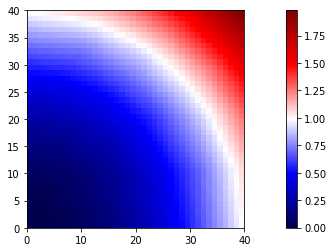

In [55]:
plt.pcolormesh(torch.reshape(z_validation, (grid_length, grid_length)).detach().numpy(), cmap="seismic")
plt.colorbar()
plt.axis("square")

In [56]:
"""
Error with respect to true function
"""
plt.figure()


TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

<Figure size 432x288 with 0 Axes>